In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# TODO: use new database of race and names
!unzip /content/drive/MyDrive/CS329R/329RFinalProjectScripts/merged_file.csv.zip

Archive:  /content/drive/MyDrive/CS329R/329RFinalProjectScripts/merged_file.csv.zip
  inflating: merged_file.csv         
  inflating: __MACOSX/._merged_file.csv  


In [ ]:
import pandas as pd
data = pd.read_json(path_or_buf='/content/annotated-mimic-iv-discharge-summaries-for-a-study-on-deidentification-of-names-1.0/general/input/notes-input.jsonl', lines=True)
first_names = pd.read_csv(filepath_or_buffer='/content/annotated-mimic-iv-discharge-summaries-for-a-study-on-deidentification-of-names-1.0/general/input/names-first.csv')
last_names = pd.read_csv(filepath_or_buffer='/content/annotated-mimic-iv-discharge-summaries-for-a-study-on-deidentification-of-names-1.0/general/input/names-last.csv')
print(data.head())
print(first_names.head())
print(last_names.head())

<ipython-input-2-b719e7e10942>:2: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_json(path_or_buf='/content/annotated-mimic-iv-discharge-summaries-for-a-study-on-deidentification-of-names-1.0/general/input/notes-input.jsonl', lines=True)


ValueError: Expected object or value

In [ ]:
# # get race, gender pair
# import re
# def get_demo(fname, lname, fnames, lnames):
#   fpred = fnames[fnames['Name'] == fname]
#   gender = fpred['Gender'].iloc[0]
#   lpred = lnames[lnames['Last'] == lname]

#   # Convert to strings for comparison
#   if str(fpred['Race'].iloc[0]) == str(lpred['Race'].iloc[0]):
#     return fpred['Race'].iloc[0], gender

#   # Accessing 'Rank' and 'Race' requires using .iloc[0] for Series
#   return fpred['Race'].iloc[0], gender if int(fpred['Rank'].iloc[0]) > int(lpred['Rank'].iloc[0]) else lpred['Race'].iloc[0], gender

# # Create new dataframe
# race_col = []
# gender_col = []
# for index, d in data.iterrows():
#   match = re.search(r"Name:\s*(.+?)\s*No:", d['note']).group(1).strip()
#   fname = match.split()[0]
#   lname = match.split()[1]
#   race, gender = get_demo(fname, lname, first_names, last_names)
#   race_col.append(race)
#   gender_col.append(gender)
# data.insert(1, "race", race_col)
# data.insert(2, "gender", gender_col)
# print(data)

In [ ]:
# STUDY 1: Characteristics of Records Themselves
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from collections import Counter
from tqdm import tqdm

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# Download required NLTK data files
nltk.download('punkt')
nltk.download('stopwords')

# Function to extract section content
def extract_section(pattern, text):
    match = re.search(pattern, text)
    if match:
        return match.group(1).strip()
    else:
        return ""

def clean_text(text):
    # Tokenize text into words
    tokens = nltk.word_tokenize(text)

    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Filter out tokens that contain numbers
    tokens = [token for token in tokens if not any(char.isdigit() for char in token)]

    # Apply stemming (optional)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove empty tokens
    tokens = [token for token in tokens if token]

    return tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['Name:', 'Evan', 'Anderson', 'Unit', 'No:', 'Admission', 'Date:', 'Discharge', 'Date:', 'Date', 'Birth:', 'Sex:', 'M', 'Service:', 'MEDICINE', 'Allergies:', 'Penicillins', 'Attending:', 'Zachary', 'Martin.', 'Chief', 'Complaint:', 'Back', 'Pain', 'Major', 'Surgical', 'Invasive', 'Procedure:', 'Bilateral', 'PCN', 'Placement', 'History', 'Present', 'Illness:', 'Mr.', 'Evan', 'Anderson', 'y/o', 'man', 'history', 'atrial', 'fibrillation', 'apixaban', 'initially', 'presented', 'General', 'Hospital', 'pain,', 'atrial', 'fibrillation', 'rapid', 'ventricular', 'rates', 'bilateral', 'hydronephrosis', 'secondary', 'suspected', 'metastatic', 'prostate', 'cancer,', 'transferred', 'General', 'Hospital', 'management.', 'The', 'patient', 'reports', 'history', 'bilateral', 'lower', 'pain', 'weight', 'loss.', 'He', 'reports', 'feeling', 'well,', 'morning', 'presentation', 'felt', 'lightheaded', 'changing', 'position', 'sitting', 'standing,', 'slid', 'ground.', 'He', 'denies', 'losing', 'consciousness'

KeyboardInterrupt: 

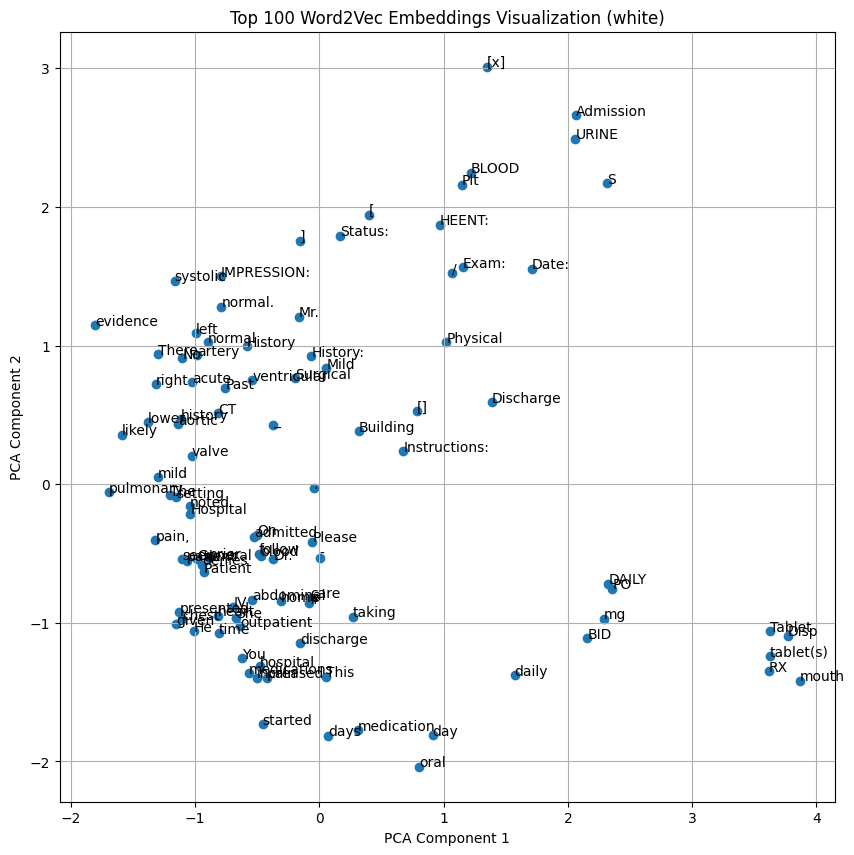

In [ ]:
# Tokenize the sentences
#TODO: Select free text parts of the note rather than test results, measurements
# Train Word2Vec model
for r in data['race'].unique():
  sentences = data[data['race'] == r]['note'].apply(clean_text).tolist()
  print(sentences[0])
  try:
    model = Word2Vec.load(f'{r}.wordvectors')
  except:
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=1, workers=4)
    model.save(f'{r}.wordvectors')

  # Count the frequency of words and get the top 100 most common
  word_counts = Counter(word for sentence in sentences for word in sentence)
  top_100_words = [word for word, _ in word_counts.most_common(100)]

  # Extract embeddings for the top 100 words
  embeddings = [model.wv[word] for word in top_100_words]

  # Reduce dimensionality for visualization using PCA
  pca = PCA(n_components=2)
  reduced_embeddings = pca.fit_transform(embeddings)

  # Plotting the word embeddings
  plt.figure(figsize=(10, 10))
  plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

  for i, word in enumerate(top_100_words):
      plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

  plt.title(f'Top 100 Word2Vec Embeddings Visualization ({r})')
  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.grid()
  plt.savefig(f'{r}.png')

In [ ]:
# STUDY 1b: Sentiment Analysis

In [ ]:
!pip install transformers
!pip install torch
!pip install datasets

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
pd1 = pd.read_csv("/content/drive/MyDrive/CS329R/329RFinalProjectScripts/merged_file_sample=5000.csv")

In [ ]:
import re

In [ ]:
sections = {
    "Chief Complaint": None,
    "History of Present Illness": None,
    "Family History": None,
    "Brief Hospital Course": None,
    "Transitional Issues": None,
    "Discharge Instructions": None,
    "Followup Instructions": None,
    "Vore": None  # Assuming "Vore" refers to a specific section that may be present
}

In [ ]:
patterns = {
    "Chief Complaint": r"(?smi)^\s*Chief Complaint(?::)?\n(.*?)^\s*Major Surgical or Invasive Procedure",
    "History of Present Illness": r"(?smi)^\s*History of Present Illness(?::)?\n(.*?)^\s*Past Medical History",
    "Family History": r"(?smi)^\s*Family History(?::)?\n(.*?)^\s*Physical Exam",
    "Brief Hospital Course": r"(?smi)^\s*Brief Hospital Course(?::)?\n(.*?)^\s*TRANSITIONAL ISSUES",
    "Transitional Issues": r"(?smi)^\s*TRANSITIONAL ISSUES(?::)?\n(.*?)^\s*Medications on Admission",
    "Discharge Instructions": r"(?smi)^\s*Discharge Instructions(?::)?\n(.*?)^\s*Followup Instructions",
    "Followup Instructions": r"(?smi)^\s*Followup Instructions(?::)?\n(.*)",
}

In [ ]:
row = pd1.iloc[0]
text = row["text"]
for section, pattern in patterns.items():
    match = re.search(pattern, text, re.DOTALL)
    if match:
        sections[section] = match.group(1).strip()

# Print parsed sections
for section, content in sections.items():
    print(f"{section}:\n{content}\n")

Chief Complaint:
nausea, vomiting, abdominal pain

History of Present Illness:
Ms. ___ is a ___ female with gastroparesis, history of 
peptic ulcer disease, POTS, asthma, irritable bowel syndrome, 
iron deficiency anemia, depression, history of PE, history of 
anorexia and bulimia, morbid obesity, who presented to the ED 
with nausea and vomiting. 

Patient reports that for the past few weeks her nausea and 
vomiting have been severe. This is associated with epigastric 
pain. She has tried to stick to bland, soft foods, and that she 
avoids fruits and vegetables for the most part. However, this 
hasn't helped much, and she still can't keep anything down. In
addition, she notes that she has had lower abdominal pain, which 
she associates with constipation. The day prior to admission she 
felt like she was going to have a large bowel movement, but very 
little came out, and her pain has continued. She reports a 
significant weight loss in the past few months. She also uses 
CBD oils and 

In [ ]:

def sep_sections(text):
    sections = {
        "Chief Complaint": None,
        "History of Present Illness": None,
        "Family History": None,
        "Brief Hospital Course": None,
        "Transitional Issues": None,
        "Discharge Instructions": None,
        "Followup Instructions": None,
        "Vore": None  # Assuming "Vore" refers to a specific section that may be present
    }
    patterns = {
      "Chief Complaint": r"(?smi)^\s*Chief Complaint(?::)?\n(.*?)^\s*Major Surgical or Invasive Procedure",
      "History of Present Illness": r"(?smi)^\s*History of Present Illness(?::)?\n(.*?)^\s*Past Medical History",
      "Family History": r"(?smi)^\s*Family History(?::)?\n(.*?)^\s*Physical Exam",
      "Brief Hospital Course": r"(?smi)^\s*Brief Hospital Course(?::)?\n(.*?)^\s*TRANSITIONAL ISSUES",
      "Transitional Issues": r"(?smi)^\s*TRANSITIONAL ISSUES(?::)?\n(.*?)^\s*Medications on Admission",
      "Discharge Instructions": r"(?smi)^\s*Discharge Instructions(?::)?\n(.*?)^\s*Followup Instructions",
      "Followup Instructions": r"(?smi)^\s*Followup Instructions(?::)?\n(.*)",
    }

    for section, pattern in patterns.items():
        match = re.search(pattern, text, re.DOTALL)
        if match:
            sections[section] = match.group(1).strip()
    return sections

def run_sent_sections(sections):
    for section, content in sections.items():
      if section == "Vore" or content == None:
        break
      print(f"{section}:{nlp(content, max_length=512, truncation=True)}\n")


In [ ]:

for idx in range(10):
    print("Index Row: " + str(idx))
    row = pd1.iloc[idx]
    text = row["text"]
    sections = sep_sections(text)
    run_sent_sections(sections)

# print(text)
# results = []
# for sentence in sentences:
#     print(sentence[:100])
#     result = nlp(text, max_length=512, truncation=True)
#     print(result)
#     results.append(result)

In [ ]:
# prompt: print all unique values in pd1

print(pd1['race'].unique())

['WHITE' 'BLACK/AFRICAN AMERICAN' 'HISPANIC/LATINO - DOMINICAN'
 'BLACK/CARIBBEAN ISLAND' 'PORTUGUESE' 'ASIAN - SOUTH EAST ASIAN'
 'HISPANIC/LATINO - CENTRAL AMERICAN' 'ASIAN - CHINESE' 'WHITE - RUSSIAN'
 'HISPANIC/LATINO - PUERTO RICAN' 'WHITE - OTHER EUROPEAN'
 'ASIAN - ASIAN INDIAN' 'AMERICAN INDIAN/ALASKA NATIVE' 'OTHER'
 'HISPANIC OR LATINO' 'HISPANIC/LATINO - CUBAN' 'WHITE - EASTERN EUROPEAN'
 'BLACK/CAPE VERDEAN' 'BLACK/AFRICAN' 'HISPANIC/LATINO - COLUMBIAN'
 'ASIAN' 'HISPANIC/LATINO - SALVADORAN' 'HISPANIC/LATINO - GUATEMALAN'
 'HISPANIC/LATINO - HONDURAN' 'SOUTH AMERICAN' 'UNKNOWN'
 'UNABLE TO OBTAIN' 'ASIAN - KOREAN' 'HISPANIC/LATINO - MEXICAN'
 'WHITE - BRAZILIAN' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'MULTIPLE RACE/ETHNICITY' 'PATIENT DECLINED TO ANSWER']


In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'pd1' is your DataFrame and 'clean_text' is your text cleaning function

# Combine all sentences from the DataFrame
sentences = []
for idx, row in pd1.iterrows():
    if idx % 1000 == 0:
      print(f"Processing row {idx}")
    if "M" in row["gender"]:
      text = sep_sections(row["text"])["Discharge Instructions"]
      if text != None:
        sentences.append(clean_text(text))
print(len(sentences))
# Train Word2Vec model on the entire corpus
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=1, workers=4)
model.save('wordvectors.model')

# Count the frequency of words and get the top 100 most common
word_counts = Counter(word for sentence in sentences for word in sentence)
top_100_words = [word for word, _ in word_counts.most_common(100)]

# Extract embeddings for the top 100 words
embeddings = [model.wv[word] for word in top_100_words if word in model.wv]

# Reduce dimensionality for visualization using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plotting the word embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

for i, word in enumerate(top_100_words):
    if word in model.wv:
        plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title('Top 100 Word2Vec Embeddings Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.savefig('word_embeddings.png')
plt.show()


Processing row 0


KeyboardInterrupt: 

In [ ]:
races = ["ASIAN", "BLACK", "WHITE", "HISPANIC"]
for race in races:
  num = 0
  total = 0
  for idx, row in pd1.iterrows():
      if idx % 1000 == 0:
        print(f"Processing row {idx}")
      if race in row["race"]:
        text = sep_sections(row["text"])["Discharge Instructions"]
        if text != None:
            total += 1
            num += 1 if "dear" in clean_text(text) else 0
  print(f"This many entries for {race}: " + str(total))
  print("Dear shows up " + str(num) + " times.")
  print(f"{race}: {num/total}")
# entries are non-blank cases of discharge instructions.
# 1449 uses of dear in White discharge instructions (2916 entries) 49.7%
# 664 uses of dear in Black discharge instructions (1276 entries) 52.0%
# 225 uses of dear in Hispanic discharge instructions (398 entries) 56.5%
# 59 uses of dear in Asian discharge instructions (105 entries) 56.2%

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for ASIAN: 105
Dear shows up 59 times.
ASIAN: 0.5619047619047619
Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for BLACK: 1276
Dear shows up 664 times.
BLACK: 0.5203761755485894
Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for WHITE: 2916
Dear shows up 1449 times.
WHITE: 0.49691358024691357
Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for HISPANIC: 398
Dear shows up 225 times.
HISPANIC: 0.5653266331658291
This many entries: 398
Dear shows up 225 times.


In [ ]:
!pip install fightin-words

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer as CV
import string
exclude = set(string.punctuation)

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''
    in_string = ''.join([ch for ch in in_string if ch not in exclude])
    in_string = in_string.lower()
    in_string = ' '.join(in_string.split())
    return in_string

def bayes_compare_language(l1, l2, ngram = 1, prior=.01, cv = None):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.

    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]
    if cv is None:
        cv = CV(decode_error = 'ignore', min_df = 1, max_df = 1, ngram_range=(1,ngram),
                binary = False,
                max_features = 15000)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v:k for k,v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = []
    for i in sorted_indices:
        return_list.append((index_to_term[i], z_scores[i]))
    return return_list

In [ ]:
l1 = clean_text('The quick brown fox jumps over the lazy pig')
l2 = clean_text('The lazy purple pig jumps over the lazier donkey')
bayes_compare_language(l1, l2)

Vocab size is 6
Comparing language...


[('donkey', -0.49877910973642914),
 ('lazier', -0.49877910973642914),
 ('purpl', -0.49877910973642914),
 ('brown', 0.49877910973642914),
 ('fox', 0.49877910973642914),
 ('quick', 0.49877910973642914)]

In [ ]:
races = ["ASIAN", "BLACK", "WHITE", "HISPANIC"]
white_di = []
total = 0
for idx, row in pd1.iterrows():
    if idx % 1000 == 0:
      print(f"Processing row {idx}")
    if "WHITE" in row["race"]:
      text = sep_sections(row["text"])["Discharge Instructions"]
      if text != None:
          total += 1
          white_di.append(clean_text(text))
print(f"This many entries for WHITE: " + str(total))

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for WHITE: 2916


In [ ]:
!pip install convokit

In [ ]:
import convokit
from convokit import Corpus, download, FightingWords

Dataset already exists at /root/.convokit/downloads/reddit-corpus-small
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 2659 valid corpus components. class2_func returned 2736 valid corpus components.
Vocab size is 2054
Comparing language...
ngram zscores computed.


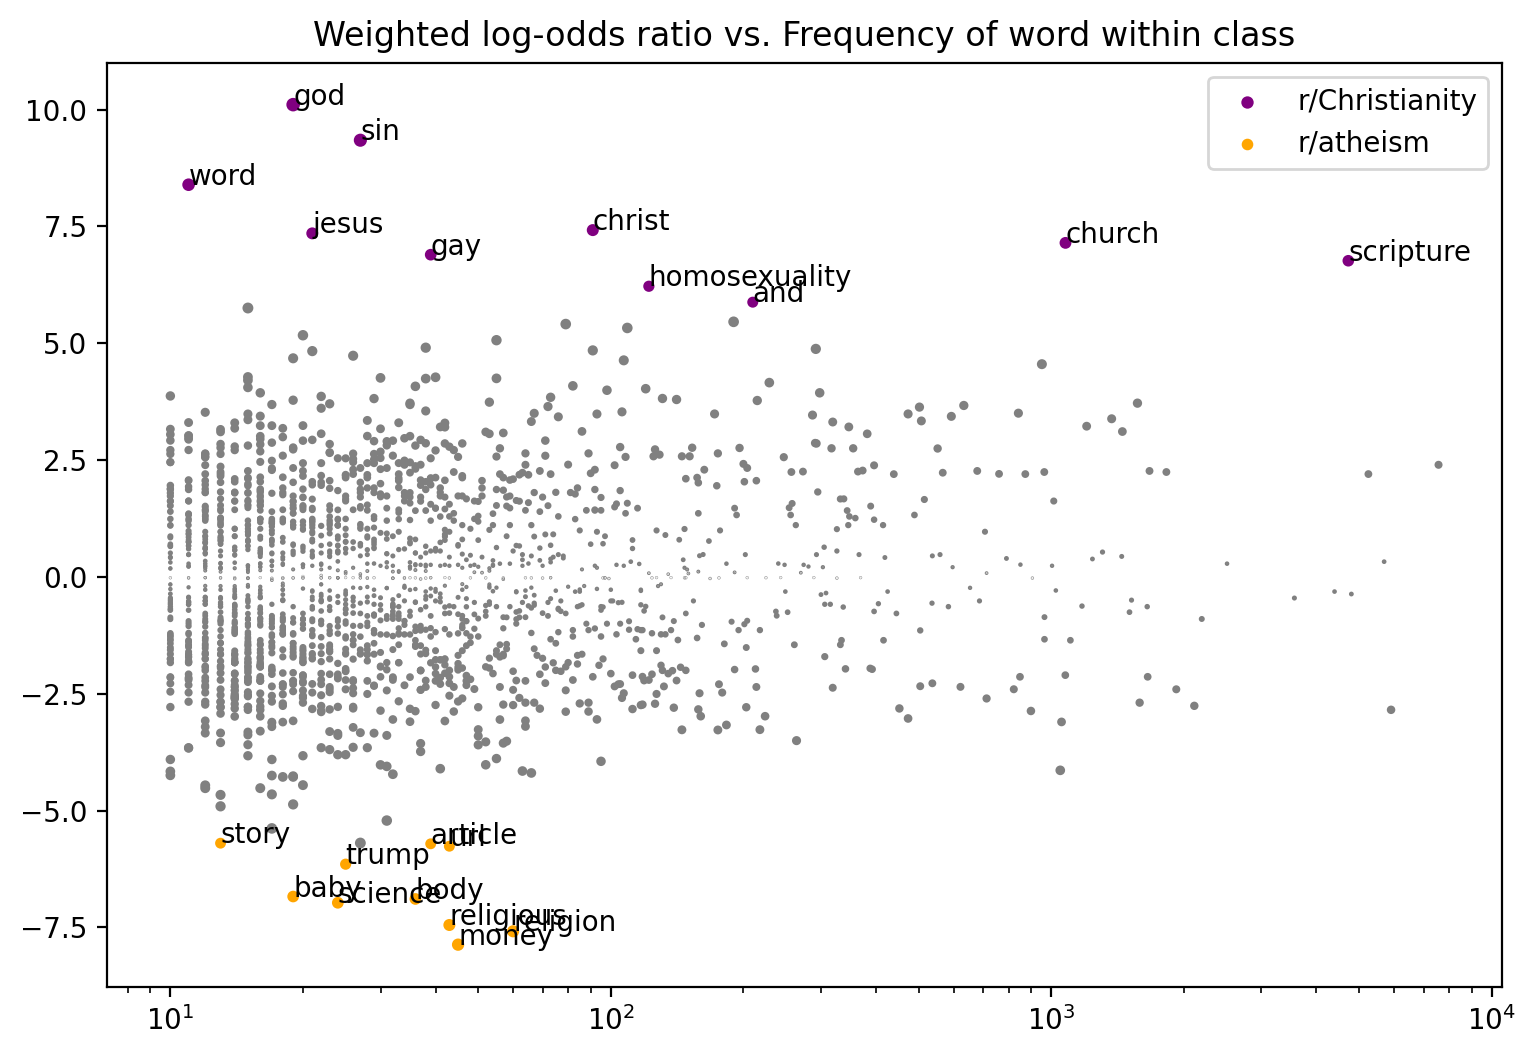

In [ ]:
corpus = Corpus(filename=download('reddit-corpus-small'))
fw = FightingWords(ngram_range=(1,1))
fw.fit(corpus, class1_func=lambda utt: utt.meta['subreddit'] == 'Christianity',
               class2_func=lambda utt: utt.meta['subreddit'] == "atheism",)
df = fw.summarize(corpus, plot=True, class1_name='r/Christianity', class2_name='r/atheism')

In [ ]:
df

,z-score,class
ngram,,
money,-7.869706,r/atheism
religion,-7.583862,r/atheism
religious,-7.448927,r/atheism
science,-6.973271,r/atheism
body,-6.891924,r/atheism
...,...,...
jesus,7.350807,r/Christianity
christ,7.420763,r/Christianity
word,8.391863,r/Christianity


In [ ]:
import pandas as pd
from convokit import Corpus

# Sample DataFrame
data = {
    'subject_id': [1, 2, 3],
    'race': ['A', 'B', 'A'],
    'gender': ['M', 'F', 'M'],
    'note_type': ['type1', 'type2', 'type1'],
    'note_id': [101, 102, 103],
    'note_seq': [1, 1, 2],
    'charttime': ['2022-01-01', '2022-01-02', '2022-01-03'],
    'storetime': ['2022-01-01T12:00', '2022-01-02T12:00', '2022-01-03T12:00'],
    'text': ['Note 1', 'Note 2', 'Note 3']
}

df = pd1

# Add required columns and use the index as 'id'
df['id'] = df['note_id'].astype(str)   # Convert index to string for ConvoKit 'id'
df['speaker'] = df['subject_id'].astype(str)  # Speaker identifier
df['conversation_id'] = df.index.astype(str)  # Conversation ID based on note sequence
df['reply_to'] = None   # Assuming no replies, set to None
df['timestamp'] = pd.to_datetime(df['charttime'])  # Use 'charttime' as timestamp

# Add race and gender as metadata fields for each utterance
df['meta.race'] = df['race']
df['meta.gender'] = df['gender']

# Construct the utterances DataFrame with metadata columns
utterances_df = df[['id', 'timestamp', 'text', 'speaker', 'reply_to', 'conversation_id', 'meta.race', 'meta.gender']]

# Create the ConvoKit corpus with both utterances and speaker data
corpus = Corpus.from_pandas(utterances_df=utterances_df)



# Print some lines from the corpus to verify inclusion of race and gender metadata in each utterance
for utt in corpus.iter_utterances():
    print(f"Utterance ID: {utt.id}")
    print(f"Speaker ID: {utt.speaker.id}")
    print(f"Race: {utt.meta['race']}")
    print(f"Gender: {utt.meta['gender']}")
    print(f"Conversation ID: {utt.conversation_id}")
    print(f"Timestamp: {utt.timestamp}")
    print(f"Text: {utt.text}")
    print("---")
    # Stop after printing a few utterances
    break

# Check the corpus structure
corpus.print_summary_stats()


5000it [00:02, 2298.91it/s]


Utterance ID: 16124481-DS-50
Speaker ID: 16124481
Race: WHITE
Gender: F
Conversation ID: 0
Timestamp: 2135-08-23 00:00:00
Text:  
Name:  ___                   Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: MEDICINE
 
Allergies: 
Erythromycin Base / Augmentin / Penicillins / Effexor
 
Attending: ___.
 
Chief Complaint:
nausea, vomiting, abdominal pain
 
Major Surgical or Invasive Procedure:
___ placement

 
History of Present Illness:
Ms. ___ is a ___ female with gastroparesis, history of 
peptic ulcer disease, POTS, asthma, irritable bowel syndrome, 
iron deficiency anemia, depression, history of PE, history of 
anorexia and bulimia, morbid obesity, who presented to the ED 
with nausea and vomiting. 

Patient reports that for the past few weeks her nausea and 
vomiting have been severe. This is associated with epigastric 
pain. She has tried to stick to bland, soft foods, and that she 
avoids fruits and veg

Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 2868 valid corpus components. class2_func returned 1242 valid corpus components.
Vocab size is 11610
Comparing language...
ngram zscores computed.


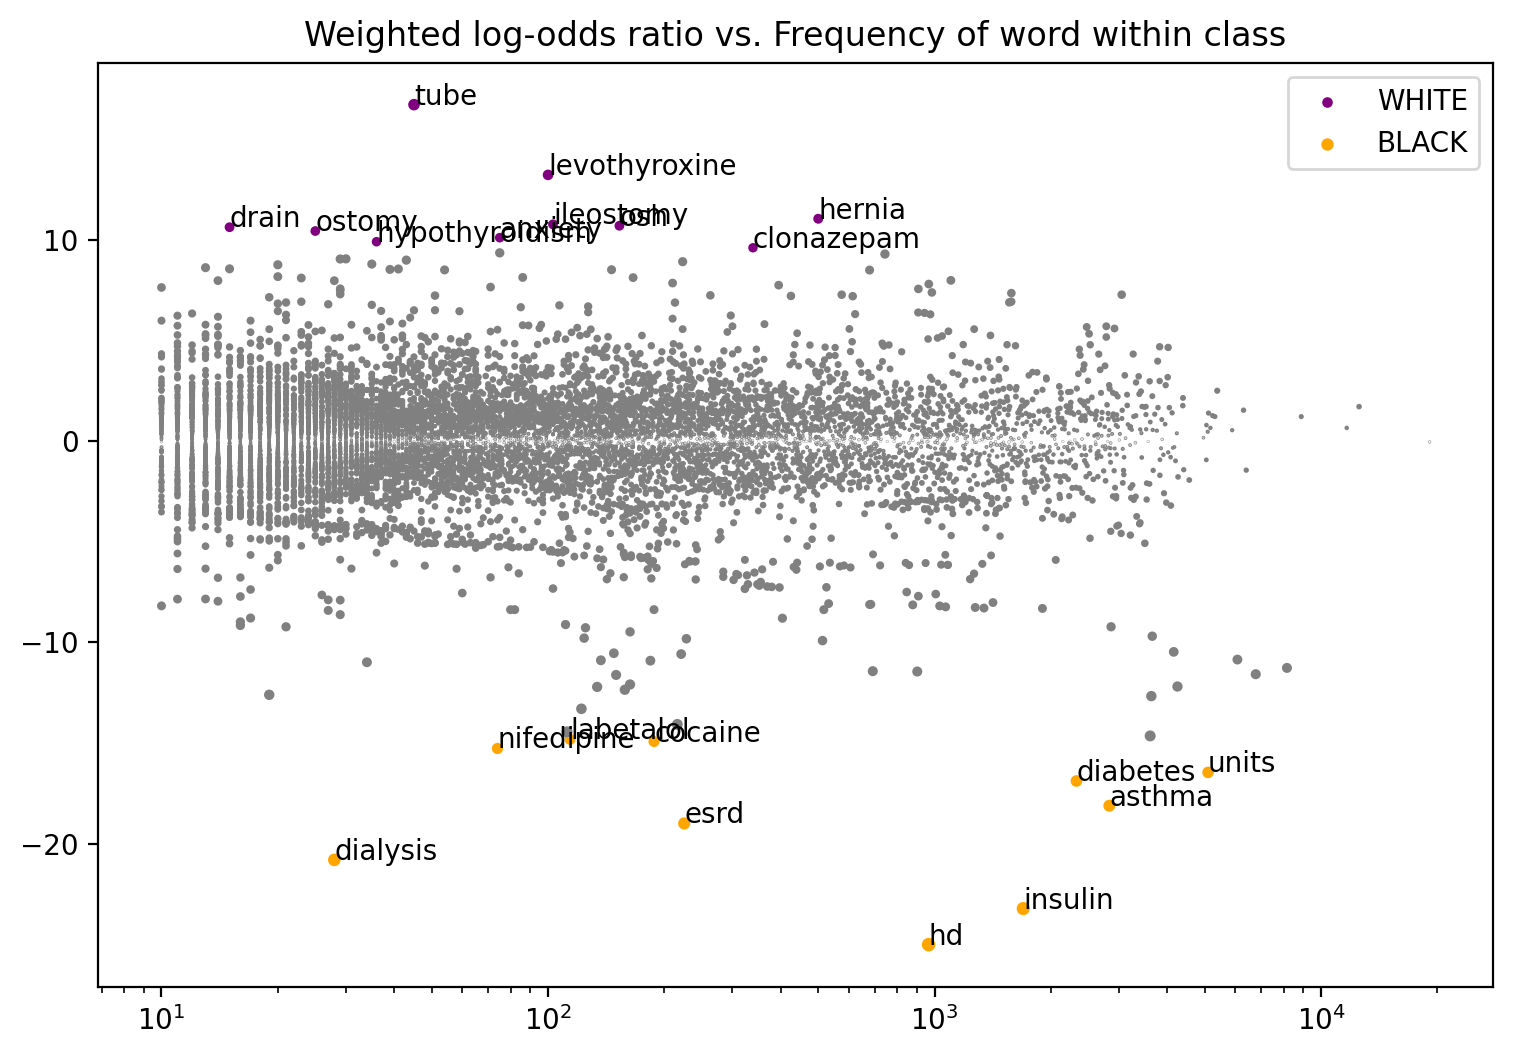

In [ ]:
fw = FightingWords(ngram_range=(1,1))
fw.fit(corpus, class1_func=lambda utt: "WHITE" in utt.meta['race'],
               class2_func=lambda utt: "BLACK" in utt.meta['race'],)
df = fw.summarize(corpus, plot=True, class1_name='WHITE', class2_name='BLACK')

In [ ]:
df

,z-score,class
ngram,,
hd,-25.011866,BLACK
insulin,-23.218788,BLACK
dialysis,-20.801422,BLACK
esrd,-18.993435,BLACK
asthma,-18.111173,BLACK
...,...,...
osh,10.688119,WHITE
ileostomy,10.757084,WHITE
hernia,11.034852,WHITE


In [ ]:
races = ["ASIAN", "BLACK", "WHITE", "HISPANIC"]
black_di = []
total = 0
for idx, row in pd1.iterrows():
    if idx % 1000 == 0:
      print(f"Processing row {idx}")
    if "BLACK" in row["race"]:
      text = sep_sections(row["text"])["Discharge Instructions"]
      if text != None:
          total += 1
          black_di.append(clean_text(text))
print(f"This many entries for BLACK: " + str(total))

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for BLACK: 1276


In [ ]:
races = ["ASIAN", "BLACK", "WHITE", "HISPANIC"]
asian_di = []
total = 0
for idx, row in pd1.iterrows():
    if idx % 1000 == 0:
      print(f"Processing row {idx}")
    if "ASIAN" in row["race"]:
      text = sep_sections(row["text"])["Discharge Instructions"]
      if text != None:
          total += 1
          asian_di.append(clean_text(text))
print(f"This many entries for ASIAN: " + str(total))

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for ASIAN: 105


In [ ]:
races = ["ASIAN", "BLACK", "WHITE", "HISPANIC"]
hispanic_di = []
total = 0
for idx, row in pd1.iterrows():
    if idx % 1000 == 0:
      print(f"Processing row {idx}")
    if "HISPANIC" in row["race"]:
      text = sep_sections(row["text"])["Discharge Instructions"]
      if text != None:
          total += 1
          hispanic_di.append(clean_text(text))
print(f"This many entries for HISPANIC: " + str(total))

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for HISPANIC: 398


In [ ]:
print("White vs. Black")
fightin_words = bayes_compare_language([item for row in white_di for item in row], [item for row in black_di for item in row])


White vs. Black
Vocab size is 2533
Comparing language...
[('zyrtec', -0.5704941900553712), ('runni', -0.5704941900553712), ('rout', -0.5704941900553712), ('exerb', -0.5704941900553712), ('exeri', -0.5704941900553712), ('exersic', -0.5704941900553712), ('expel', -0.5704941900553712), ('extendedreleas', -0.5704941900553712), ('ritalin', -0.5704941900553712), ('extrastrength', -0.5704941900553712), ('risli', -0.5704941900553712), ('ruq', -0.5704941900553712), ('exup', -0.5704941900553712), ('ezetimib', -0.5704941900553712), ('faith', -0.5704941900553712), ('fatal', -0.5704941900553712), ('femoralabov', -0.5704941900553712), ('femoralposterior', -0.5704941900553712), ('retun', -0.5704941900553712), ('retroperiton', -0.5704941900553712), ('fibromyalgiachron', -0.5704941900553712), ('financi', -0.5704941900553712), ('fingernail', -0.5704941900553712), ('riskyimpuls', -0.5704941900553712), ('fingertip', -0.5704941900553712), ('evideonc', -0.5704941900553712), ('everolimusafinitor', -0.5704941

In [ ]:
print(sorted(fightin_words, key= lambda x: x[1])[:10])

[('zyrtec', -0.5704941900553712), ('runni', -0.5704941900553712), ('rout', -0.5704941900553712), ('exerb', -0.5704941900553712), ('exeri', -0.5704941900553712), ('exersic', -0.5704941900553712), ('expel', -0.5704941900553712), ('extendedreleas', -0.5704941900553712), ('ritalin', -0.5704941900553712), ('extrastrength', -0.5704941900553712)]


In [ ]:
print(sorted(fightin_words, reverse=True, key= lambda x: x[1])[:10])

[('nitro', 0.3482015391809274), ('nitrogylcerin', 0.3482015391809274), ('verg', 0.3482015391809274), ('pole', 0.3482015391809274), ('posaconazol', 0.3482015391809274), ('yard', 0.3482015391809274), ('pneumovax', 0.3482015391809274), ('nivolumab', 0.3482015391809274), ('xweek', 0.3482015391809274), ('pneumonialung', 0.3482015391809274)]


In [ ]:
print("White vs. Black")
fightin_words = bayes_compare_language([item for row in white_di for item in row], [item for row in black_di for item in row])
print(sorted(fightin_words, key= lambda x: x[1])[:10])
print(sorted(fightin_words, reverse=True, key= lambda x: x[1])[:10])

White vs. Black
Vocab size is 2533
Comparing language...
[('zyrtec', -0.5704941900553712), ('runni', -0.5704941900553712), ('rout', -0.5704941900553712), ('exerb', -0.5704941900553712), ('exeri', -0.5704941900553712), ('exersic', -0.5704941900553712), ('expel', -0.5704941900553712), ('extendedreleas', -0.5704941900553712), ('ritalin', -0.5704941900553712), ('extrastrength', -0.5704941900553712)]
[('nitro', 0.3482015391809274), ('nitrogylcerin', 0.3482015391809274), ('verg', 0.3482015391809274), ('pole', 0.3482015391809274), ('posaconazol', 0.3482015391809274), ('yard', 0.3482015391809274), ('pneumovax', 0.3482015391809274), ('nivolumab', 0.3482015391809274), ('xweek', 0.3482015391809274), ('pneumonialung', 0.3482015391809274)]


In [ ]:
print("White vs. Hispanic")
fightin_words = bayes_compare_language([item for row in white_di for item in row], [item for row in hispanic_di for item in row])
print(sorted(fightin_words, key= lambda x: x[1])[:10])
print(sorted(fightin_words, reverse=True, key= lambda x: x[1])[:10])

White vs. Hispanic
Vocab size is 2543
Comparing language...
[('ía', -0.6207070610519266), ('electrocradiogram', -0.6207070610519266), ('rough', -0.6207070610519266), ('elud', -0.6207070610519266), ('embargo', -0.6207070610519266), ('romki', -0.6207070610519266), ('empeoramiento', -0.6207070610519266), ('empezamo', -0.6207070610519266), ('employ', -0.6207070610519266), ('employe', -0.6207070610519266)]
[('phospor', 0.29805977427885477), ('movementstress', 0.29805977427885477), ('placent', 0.29805977427885477), ('moxifloxacin', 0.29805977427885477), ('verg', 0.29805977427885477), ('pinprick', 0.29805977427885477), ('verpamil', 0.29805977427885477), ('version', 0.29805977427885477), ('mrimrv', 0.29805977427885477), ('petroleum', 0.29805977427885477)]


In [ ]:
print("White vs. Asian")
fightin_words = bayes_compare_language([item for row in white_di for item in row], [item for row in asian_di for item in row])
print(sorted(fightin_words, key= lambda x: x[1])[:10])
print(sorted(fightin_words, reverse=True, key= lambda x: x[1])[:10])

White vs. Asian
Vocab size is 2311
Comparing language...
[('repetit', -0.7767578520613523), ('phlebotomist', -0.7767578520613523), ('ketoacidso', -0.7767578520613523), ('bolu', -0.7767578520613523), ('antibiotoc', -0.7767578520613523), ('psychotherapi', -0.7767578520613523), ('dextromethorphangauifenesin', -0.7767578520613523), ('antibio', -0.7767578520613523), ('committe', -0.7767578520613523), ('dip', -0.7767578520613523)]
[('pneumatosi', 0.14283759477862135), ('painnauseavomit', 0.14283759477862135), ('pnemonia', 0.14283759477862135), ('pne', 0.14283759477862135), ('painless', 0.14283759477862135), ('pleurit', 0.14283759477862135), ('plexu', 0.14283759477862135), ('palatin', 0.14283759477862135), ('pneumocyst', 0.14283759477862135), ('plesur', 0.14283759477862135)]


In [ ]:

#TODO: Write something to process something like summarize_medical_record(d['note'][d['note'].find('Discharge Instructions:'):])
# import pandas as pd
# from transformers import pipeline

# from huggingface_hub import InferenceClient

# client = InferenceClient(api_key="YOUR_HUGGINGFACE_TOKEN")
# def summarize_medical_record(text):
#   messages = [
#     { "role": "user", "content": "Identify at least three specific goals of care in this letter: " + text }
#   ]

#   stream = client.chat.completions.create(
#       model="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
#     messages=messages,
#     max_tokens=500,
#     stream=True
#   )
#   res = ""
#   for chunk in stream:
#       res += chunk.choices[0].delta.content
#       print(res)
#   return res


# # Load the summarization pipeline
# summarizer = pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", device="cuda")

# # Define a more detailed prompt and function to summarize medical records
# prompt = (
#     "User: Identify at least three specific goals of care in this letter: "
# )

# def summarize_medical_record(text):
#     # Combine the prompt with the patient information
#     full_input = prompt + text

#     return pipe(prompt)

In [ ]:
races = ["ASIAN", "BLACK", "WHITE", "HISPANIC"]
word = "zyrtec"
for race in races:
  num = 0
  total = 0
  for idx, row in pd1.iterrows():
      if idx % 1000 == 0:
        print(f"Processing row {idx}")
      if race in row["race"]:
        text = row["text"]
        if text != None:
            total += 1
            num += 1 if word in clean_text(text) else 0
  print(f"This many entries for {race}: " + str(total))
  print(f"{word} shows up " + str(num) + " times.")
  print(f"{race}: {num/total}")
# entries are non-blank cases of discharge instructions.
# 1449 uses of dear in White discharge instructions (2916 entries) 49.7%
# 664 uses of dear in Black discharge instructions (1276 entries) 52.0%
# 225 uses of dear in Hispanic discharge instructions (398 entries) 56.5%
# 59 uses of dear in Asian discharge instructions (105 entries) 56.2%

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for ASIAN: 111
{word} shows up 0 times.
ASIAN: 0.0
Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for BLACK: 1297
{word} shows up 2 times.
BLACK: 0.0015420200462606013
Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for WHITE: 2976
{word} shows up 25 times.
WHITE: 0.008400537634408602
Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
This many entries for HISPANIC: 401
{word} shows up 3 times.
HISPANIC: 0.007481296758104738
